# Synthetic experiments

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qubit_measurement_analysis.data import SingleShot, ShotCollection

from qubit_measurement_analysis.classification.metrics import Metrics as M 

from denoiser.config import *
from data_generator import generate_relaxation_data

import scienceplots

plt.style.use(["science", "no-latex"])
# plt.style.use("default")


fontsize = 12
plt.rcParams.update({"font.size": fontsize, "lines.linewidth": 1.5})

In [3]:
def generate_dataset(batch_size: int, seed: int = 42):
    """Generate noisy and clean datasets."""
    # Generate noisy data
    noisy_data, labels = generate_relaxation_data(
        batch_size=batch_size,
        meas_time=MEAS_TIME,
        I_amp_1=-200,
        Q_amp_1=400,
        I_amp_0=-250,
        Q_amp_0=200,
        relax_time_transition=1e-9,
        T1=50e-6,
        gauss_noise_amp=NOISE_AMP,
        qubit=1,
        seed=seed,
    )

    # Generate clean data (low noise)
    clean_data, labels = generate_relaxation_data(
        batch_size=batch_size,
        meas_time=MEAS_TIME,
        I_amp_1=-200,
        Q_amp_1=400,
        I_amp_0=-250,
        Q_amp_0=200,
        relax_time_transition=1e-9,
        T1=50e-6,
        gauss_noise_amp=10,  # Low noise for "clean" data
        qubit=1,
        seed=seed,
    )

    noisy_sc = ShotCollection(_use_cython=True)
    noisy_sc.extend(
        [
            SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True)
            for value, qubits_classes in zip(noisy_data, labels)
        ]
    )

    ideal_sc = ShotCollection(_use_cython=True)
    ideal_sc.extend(
        [
            SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True)
            for value, qubits_classes in zip(clean_data, labels)
        ]
    )

    return noisy_sc, ideal_sc


## Data Generation

In [4]:
noisy_sc, ideal_sc = generate_dataset(3000)

{'1': 2883, '2': 117}


<Axes: >

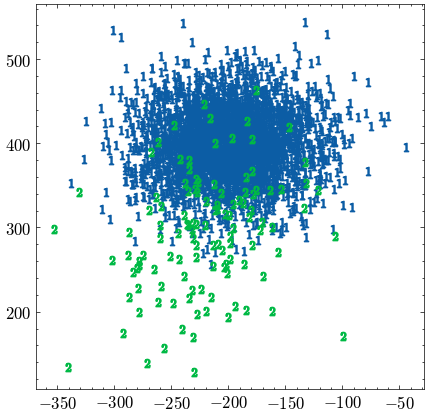

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
print(noisy_sc.counts)
noisy_sc.mean().compute().scatter(ax)

In [6]:
# https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb 

def calculate_snr(pred, target):
    """
    Calculate Signal-to-Noise Ratio in decibels.

    SNR = 10 * log10(signal_power / noise_power)
    where noise is the difference between prediction and target
    """
    # Calculate noise as the difference between prediction and target
    noise = pred - target

    # Calculate powers (mean squared values)
    signal_power = np.mean(target**2, axis=-1)
    noise_power = np.mean(noise**2, axis=-1)

    # Avoid division by zero and log of zero
    eps = 1e-10
    snr = 10 * np.log10((signal_power + eps) / (noise_power + eps))

    return snr

In [7]:
pred = noisy_sc.all_values[:,0]
target = ideal_sc.all_values[:,0]
calculate_snr(pred, target)

array([ 7.4577     -7.8395557j,  2.8028955  +5.6965857j,
       -0.91293216 +7.209073j , ...,  2.9833364  +5.6720114j,
        1.7695127 +12.525449j ,  1.4987645  +5.5620675j], dtype=complex64)

## Signal denoising before clusterisation  
How denoising methods unvail relaxation events

In [26]:
import pywt

def uwt_denoise_batch(noisy_signals, wavelet='db1', level=3, threshold_type='soft', threshold_factor=1.0):
    """
    Denoise a batch of signals using Undecimated Wavelet Transform (UWT).
    
    Args:
        noisy_signals (numpy.ndarray): Array of shape (batch, signal_len) containing noisy signals.
        wavelet (str): Wavelet type to use (e.g., 'db1', 'sym4').
        level (int): Number of decomposition levels.
        threshold_type (str): Type of thresholding ('soft' or 'hard').
        threshold_factor (float): Scaling factor for noise threshold.
    
    Returns:
        numpy.ndarray: Denoised signals of the same shape as `noisy_signals`.
    """
    batch_size, signal_len = noisy_signals.shape
    denoised_signals = np.zeros_like(noisy_signals)
    
    for i in range(batch_size):
        # Decompose signal using UWT
        coeffs = pywt.swt(noisy_signals[i], wavelet, level=level)
        
        # Thresholding coefficients
        denoised_coeffs = []
        for cA, cD in coeffs:
            # Estimate noise threshold
            sigma = np.median(np.abs(cD)) / 0.6745  # Median Absolute Deviation (MAD) estimate
            threshold = threshold_factor * sigma * np.sqrt(2 * np.log(signal_len))
            
            if threshold_type == 'soft':
                cD = pywt.threshold(cD, threshold, mode='soft')
            elif threshold_type == 'hard':
                cD = pywt.threshold(cD, threshold, mode='hard')
            else:
                raise ValueError("Invalid threshold_type. Choose 'soft' or 'hard'.")
            
            denoised_coeffs.append((cA, cD))
        
        # Reconstruct signal from thresholded coefficients
        denoised_signals[i] = pywt.iswt(denoised_coeffs, wavelet)
    
    return denoised_signals

In [8]:
noisy_sc_2 = noisy_sc.filter_by_pattern("2")
ideal_sc_2 = ideal_sc.filter_by_pattern("2")

### Mean-convolve vs Whittaker-Eilers

In [63]:
denoised_signals = uwt_denoise_batch(noisy_sc_2.all_values[:,0].imag, wavelet='db1', level=3, threshold_type='hard')
denoised_signals.shape

(117, 1000)

In [64]:
size = 5
stride = 2
lamb = 100

mean_conv_noisy_sc = noisy_sc_2.mean_convolve_all(size, stride).compute()
mean_conv_ideal_sc = ideal_sc_2.mean_convolve_all(size, stride).compute()

whit_ei_noisy_sc = noisy_sc_2.whittaker_eilers_smoother_all(lamb, 2).compute()

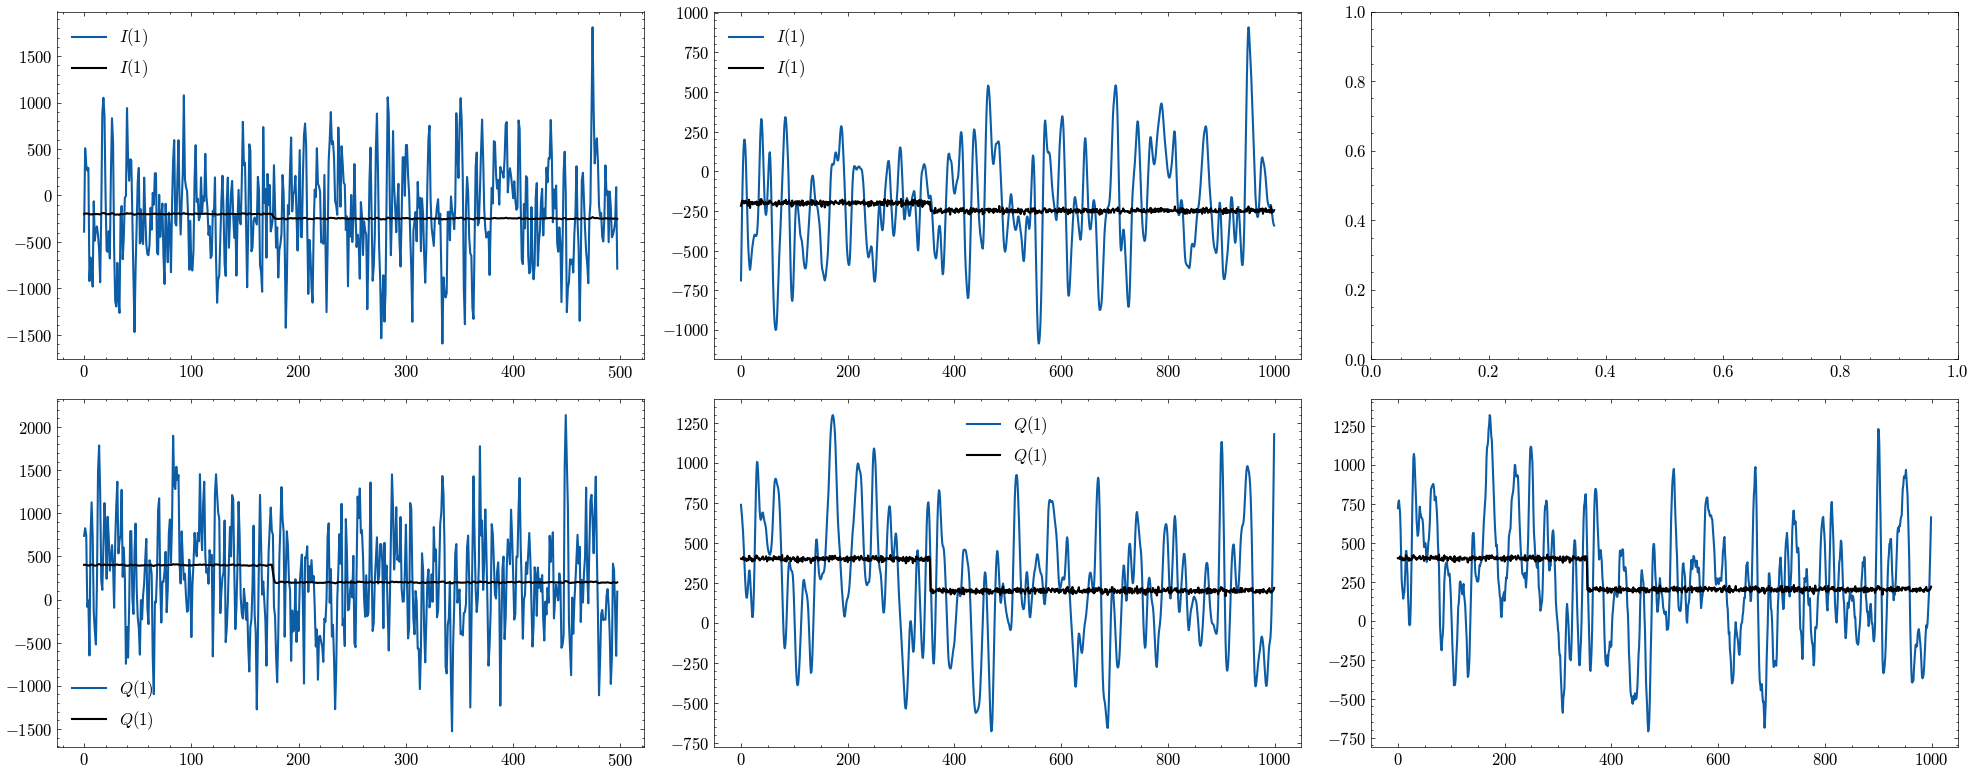

In [94]:
ind = np.random.randint(0, len(noisy_sc_2))
fig, ax = plt.subplots(2, 3, figsize=(20,8))

# noisy_sc_2[ind].plot(ax[0,0], quadrature=False, color='grey', alpha=0.5)
mean_conv_noisy_sc[ind].plot(ax[0,0], quadrature=False)
mean_conv_ideal_sc[ind].plot(ax[0,0], quadrature=False, color='black')
ax[0,0].legend()
mean_conv_noisy_sc[ind].plot(ax[1,0], in_phase=False)
mean_conv_ideal_sc[ind].plot(ax[1,0], in_phase=False, color='black')
ax[1,0].legend()

whit_ei_noisy_sc[ind].plot(ax[0,1], quadrature=False)
ideal_sc_2[ind].plot(ax[0,1], quadrature=False, color='black')
ax[0,1].legend()
whit_ei_noisy_sc[ind].plot(ax[1,1], in_phase=False)
ideal_sc_2[ind].plot(ax[1,1], in_phase=False, color='black')
ax[1,1].legend()

ax[1,2].plot(denoised_signals[ind])
ideal_sc_2[ind].plot(ax[1,2], in_phase=False, color='black')
ax[1,1].legend()

plt.tight_layout()

### Denoise Autoencoder

#### Inference

In [27]:
from pathlib import Path
from denoiser.inference import denoise_signal

In [30]:
# Get latest model from results
results_dir = Path("results")
latest_run = max(results_dir.glob("*"), key=lambda p: p.stat().st_mtime)
model_path = latest_run / "checkpoints" / "model.pt"

# Signals to denoise
ind = np.random.randint(0, len(noisy_sc_2))
input_signals = noisy_sc_2.all_values[ind,0]
real_signals = ideal_sc_2.all_values[ind,0]

# Denoise signal
denoised_data = denoise_signal(input_signals, model_path)

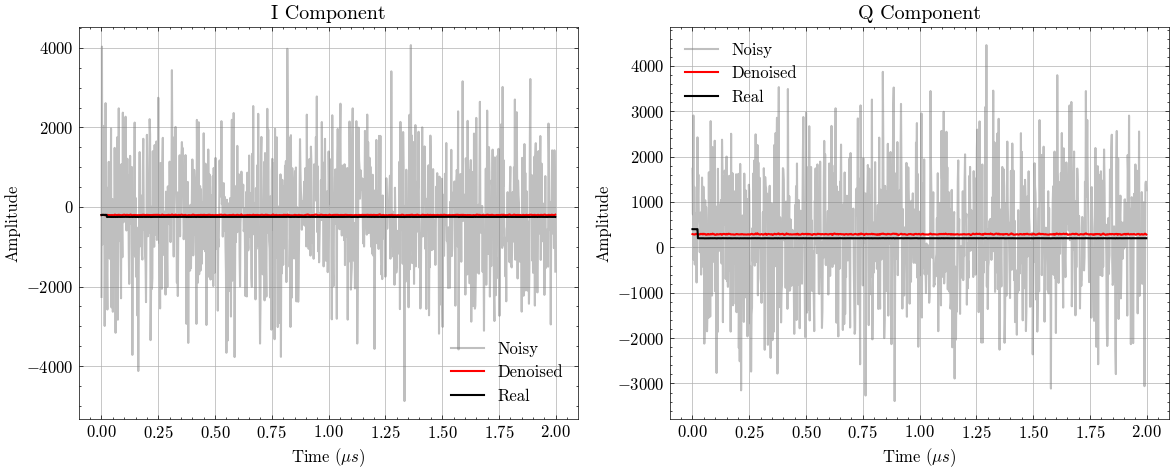

In [37]:
# Plot results
plt.figure(figsize=(12, 5))

# Plot I component
plt.subplot(1, 2, 1)
plt.plot(MEAS_TIME * 1e6, input_signals.real, "gray", alpha=0.5, label="Noisy")
plt.plot(MEAS_TIME * 1e6, denoised_data.real, "r", label="Denoised")
plt.plot(MEAS_TIME * 1e6, real_signals.real, "black", label="Real")
plt.title("I Component")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

# Plot Q component
plt.subplot(1, 2, 2)
plt.plot(MEAS_TIME * 1e6, input_signals.imag, "gray", alpha=0.5, label="Noisy")
plt.plot(MEAS_TIME * 1e6, denoised_data.imag, "r", label="Denoised")
plt.plot(MEAS_TIME * 1e6, real_signals.imag, "black", label="Real")
plt.title("Q Component")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Train

In [12]:
from denoiser.train import setup_directories, prepare_data, plot_training_history, plot_example_results
from denoiser.model import DenoisingCNN
from denoiser.train import train_model

import torch.nn as nn
import torch

import json

**Generate Dataset**

In [4]:
noisy_sc, ideal_sc = generate_dataset(80000)
print(noisy_sc.counts)

{'2': 3148, '1': 76852}


In [5]:
noisy_data = ShotCollection(_use_cython=True)
clean_data = ShotCollection(_use_cython=True)

noisy_data.extend(noisy_sc.filter_by_pattern('1')[:3000])
noisy_data.extend(noisy_sc.filter_by_pattern('2')[:3000])

clean_data.extend(ideal_sc.filter_by_pattern('1')[:3000])
clean_data.extend(ideal_sc.filter_by_pattern('2')[:3000])

noisy_data.shuffle(RANDOM_SEED)
clean_data.shuffle(RANDOM_SEED)

In [6]:
# Setup directories
run_dir = setup_directories()

In [9]:
# Prepare data loaders
print("Preparing data loaders...")
train_loader, val_loader = prepare_data(
    noisy_data=noisy_data.all_values[:,0],
    clean_data=clean_data.all_values[:,0],
    train_ratio=TRAIN_VAL_SPLIT,
    batch_size=TRAIN_BATCH_SIZE,
    device=DEVICE,
)

Preparing data loaders...


In [11]:
# Initialize model
print("Initializing model...")
model = DenoisingCNN(
    input_channels=INPUT_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    num_residual_blocks=NUM_RESIDUAL_BLOCKS,
    kernel_size=KERNEL_SIZE,
).to(DEVICE)

# Setup training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Initializing model...


In [14]:
# Train model
print("Starting training...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    early_stopping_patience=10,
)

# Save results
print("Saving results...")

# Save model
torch.save(model.state_dict(), run_dir / "checkpoints" / "model.pt")

# Save training history
with open(run_dir / "history.json", "w") as f:
    json.dump(history, f, indent=4)

# Plot results
plot_training_history(history, run_dir)
plot_example_results(model, noisy_data, clean_data, run_dir, DEVICE)

print(f"Training complete! Results saved in {run_dir}")

Starting training...
Epoch 1/100
Train Loss: 88568.538750
Val Loss: 71494.732525
Val SNR: 0.27 dB
----------------------------------------
Epoch 2/100
Train Loss: 82151.566823
Val Loss: 64545.941303
Val SNR: 0.72 dB
----------------------------------------
Epoch 3/100
Train Loss: 74191.915365
Val Loss: 57240.154194
Val SNR: 1.24 dB
----------------------------------------


KeyboardInterrupt: 